In [96]:
# Import Required Modules.
from statistics import mean, stdev
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

In [97]:
df = pd.read_csv("./data/GenshinReview.csv")
df.head()
score = df['score'].tolist()
content = df['content'].tolist()

In [98]:
# Load BERT tokenizer
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data using BERT tokenizer
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in content]

In [99]:
# Statistical summary of numeric columns ('score')
print("\nStatistical Summary of 'score' column:")
print(df['score'].describe())


Statistical Summary of 'score' column:
count    2000.000000
mean        3.979500
std         1.254937
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64


In [100]:
# Display the first few rows of the 'score' column
print("\nFirst Few Scores:")
print(df['score'].head())


First Few Scores:
0    5
1    4
2    4
3    4
4    4
Name: score, dtype: int64


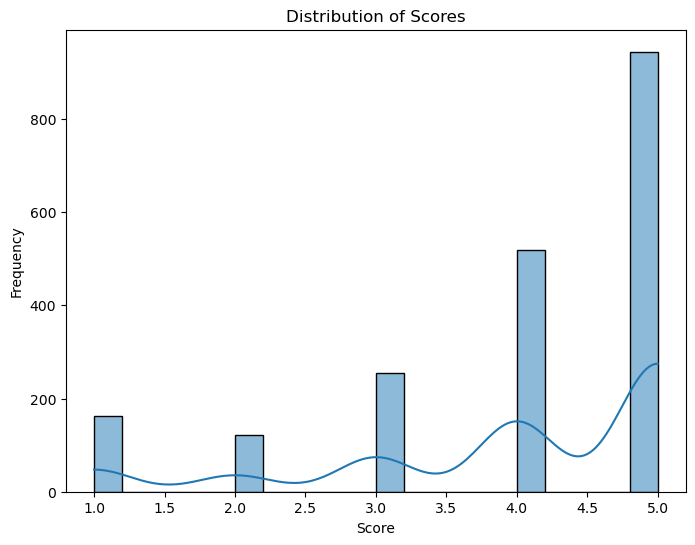

In [101]:
# Visualizing the distribution of scores using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['score'], bins=20, kde=True)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


First Few Content:
0    the game is great audio background etc are all...
1    the world building characters art design and g...
2    this game is fun but at the time that fontaine...
3    this game is beautiful and the game is very fu...
4    lost on furina banner but all together it is a...
Name: content, dtype: object


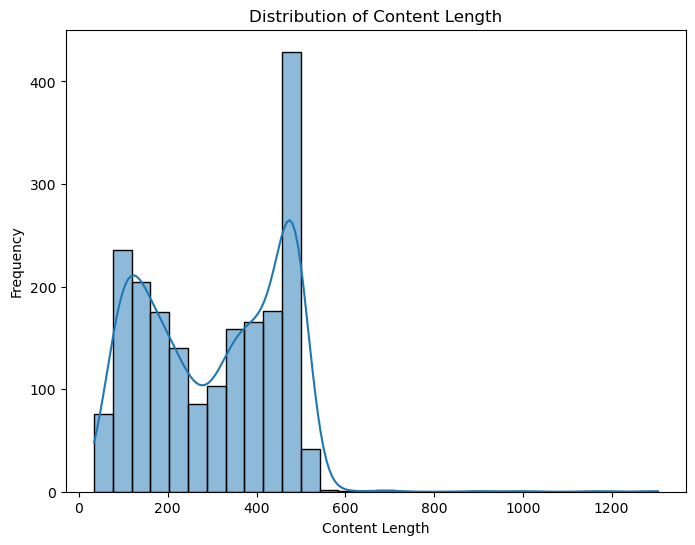

In [102]:
print("\nFirst Few Content:")
print(df['content'].head())

# Calculating the length of content (number of characters) and visualizing its distribution
content_length = df['content'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(content_length, bins=30, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

In [103]:
# Tokenize the 'content' column into words and sentences using NLTK
nltk.download('punkt')  

# Tokenize the 'content' column into words
df['content_words'] = df['content'].apply(lambda x: word_tokenize(str(x)))

# Tokenize the 'content' column into sentences
df['content_sentences'] = df['content'].apply(lambda x: sent_tokenize(str(x)))

# Display the tokenized content
print("\nTokenized Content (Words):")
print(df['content_words'].head())

print("\nTokenized Content (Sentences):")
print(df['content_sentences'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Tokenized Content (Words):
0    [the, game, is, great, audio, background, etc,...
1    [the, world, building, characters, art, design...
2    [this, game, is, fun, but, at, the, time, that...
3    [this, game, is, beautiful, and, the, game, is...
4    [lost, on, furina, banner, but, all, together,...
Name: content_words, dtype: object

Tokenized Content (Sentences):
0    [the game is great audio background etc are al...
1    [the world building characters art design and ...
2    [this game is fun but at the time that fontain...
3    [this game is beautiful and the game is very f...
4    [lost on furina banner but all together it is ...
Name: content_sentences, dtype: object


In [113]:
# Create a DataFrame with 'content' and 'score'
data = {'content': content, 'score': score}
df = pd.DataFrame(data)

# Apply label encoding to 'score' column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['score_encoded'] = label_encoder.fit_transform(df['score'])

# Split data into training, validation, and testing sets using encoded labels
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Extract content and encoded scores for training, validation, and testing sets
train_content = train_df['content'].tolist()
train_score_encoded = train_df['score_encoded'].tolist()

val_content = val_df['content'].tolist()
val_score_encoded = val_df['score_encoded'].tolist()

test_content = test_df['content'].tolist()
test_score_encoded = test_df['score_encoded'].tolist()

In [114]:
# Tokenize the text data (Example: using CountVectorizer for tokenization)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_content).toarray()  # Convert to dense array
X_val = vectorizer.transform(val_content).toarray()  # Convert to dense array
X_test = vectorizer.transform(test_content).toarray()  # Convert to dense array

# Convert labels to tensors
y_train = torch.tensor(train_score_encoded)
y_val = torch.tensor(val_score_encoded)
y_test = torch.tensor(test_score_encoded)

train_dataset = TensorDataset(torch.tensor(X_train), y_train)
val_dataset = TensorDataset(torch.tensor(X_val), y_val)
test_dataset = TensorDataset(torch.tensor(X_test), y_test)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [106]:
#model
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Input layer to hidden layer
        self.relu = nn.ReLU()  # Activation function (ReLU)
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for classification
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        output = self.softmax(x)
        return output

In [107]:
# Example data and labels
data = torch.randn(100, 10)  # Example data (100 samples, 10 features)
labels = torch.randint(0, 3, (100,))  # Example labels (100 samples, 3 classes)

# Create a DataLoader
batch_size = 16
tensor_data = torch.utils.data.TensorDataset(data, labels)
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

# Create an instance of SimpleModel
input_size = X_train.shape[1]
output_size = len(set(train_score_encoded))
model = SimpleModel(input_size, output_size)

In [108]:
# Model definition
input_size = X_train.shape[1]
output_size = len(set(train_score_encoded))
model = SimpleModel(input_size, output_size)

# Setup the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [109]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [110]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.float())
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [111]:
num_epochs = 10 

# train model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


IndexError: Target 5 is out of bounds.